# **First we build a standard convolutional autoencoder to reconstruct MNIST digit**
 * ## **We want to have a 2D embedding**

* ## As done so far, we normalize all pixel values between 0 and 1 .
* ## We configure our encoder to have 3 convolutional layers, followed by flattening and two dense layers




In [1]:
#!pip install --upgrade keras # necessary to import ops

import tensorflow as tf
import keras
from keras import ops # provides compatibility across multiple backends

from keras.datasets import mnist
import tensorflow.keras as K
from tensorflow.keras import layers
import numpy as np
(x_train, y_train), (x_test, _) = mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


--------------------------------------------

In [ ]:

# one Fully-Connected layer encoder
# latent_dim: This is the size of our encoded representations
def conv_enc(INPUT_SHAPE, latent_dim):
    model = K.Sequential([
#      input_img = layers.Input(shape=INPUT_SHAPE)
      layers.Conv2D(16, (3, 3), strides = 1,
                    input_shape=INPUT_SHAPE,
                    activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2), padding='same'),
      layers.Conv2D(32, (3, 3),  strides = 1,
                    activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2), padding='same'),
      # at this point the representation is (7, 7, 32)
      layers.Flatten(),
      layers.Dense(16, activation="relu"),
      layers.Dense(latent_dim, activation="relu",
                   name="latent")
      ])
    return model

# at this point the representation is 32-dimensional
def conv_dec(latent_dim, out_activation='sigmoid'):
  model = K.Sequential([
    layers.Dense(16, activation="relu", input_shape=(latent_dim,)),
    layers.Dense(7*7*32, activation="relu"),
    layers.Reshape((7, 7, 32)),
    layers.Conv2DTranspose(32, (3, 3), strides = 2,
                  activation='relu', padding='same'),
    layers.Conv2DTranspose(16, (3, 3), strides = 2,
                  activation='relu', padding='same'),
    layers.Conv2D(1, (3, 3), activation=out_activation,
                  padding='same')
  ])
  return model


class Conv_AE(K.Model):
  def __init__(self, INPUT_SHAPE, ENCODING_DIM,
               enc_model, dec_model, out_activation='sigmoid'):
    super(Conv_AE, self).__init__()
    #############################################
    #----------ENCODER--------------------------#
    # at this point the representation is (28,28,1)-dimensional
    self.encoder = enc_model(INPUT_SHAPE, ENCODING_DIM)
    # at this point the representation is ENCODING_DIM-dimensional
    #############################################
    #----------DECODER--------------------------#
    self.decoder = dec_model(ENCODING_DIM, out_activation)

# method to encode images
  def getEncodedImage(self, image):
        encoded_image = self.encoder.predict(image)
        return encoded_image
# method to decode images
  def getDecodedImage(self, encoded_imgs):
      decoded_image = self.decoder.predict(encoded_imgs)
      return decoded_image

  def call(self, input):
    out_encoder = self.encoder(input)
    out_decoder = self.decoder(out_encoder)
    return out_decoder


In [ ]:
input_shape = tuple(x_train.shape[1:])

ENCODING_DIM = 2

autoenc_conv = Conv_AE(input_shape,
                    ENCODING_DIM,
                    conv_enc,
                    conv_dec,
                    out_activation='sigmoid')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
autoenc_conv.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        25,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,938 (116.95 KB)

 Trainable params: 29,938 (116.95 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoenc_conv.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1568)           │        26,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,721 (159.07 KB)

 Trainable params: 40,721 (159.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lr = 0.0001 # default value for Adam
autoenc_conv.compile(optimizer=K.optimizers.Adam(learning_rate=lr),
                  #loss='binary_crossentropy')
                  loss='mse')
epochs = 30
batch_size=128
autoenc_conv.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                 verbose = 2)

Epoch 1/30
469/469 - 10s - 22ms/step - loss: 0.1037
Epoch 2/30
469/469 - 2s - 4ms/step - loss: 0.0675
Epoch 3/30
469/469 - 2s - 4ms/step - loss: 0.0647
Epoch 4/30
469/469 - 2s - 5ms/step - loss: 0.0599
Epoch 5/30
469/469 - 2s - 5ms/step - loss: 0.0568
Epoch 6/30
469/469 - 2s - 5ms/step - loss: 0.0555
Epoch 7/30
469/469 - 3s - 5ms/step - loss: 0.0548
Epoch 8/30
469/469 - 2s - 4ms/step - loss: 0.0542
Epoch 9/30
469/469 - 3s - 6ms/step - loss: 0.0537
Epoch 10/30
469/469 - 2s - 5ms/step - loss: 0.0531
Epoch 11/30
469/469 - 2s - 4ms/step - loss: 0.0526
Epoch 12/30
469/469 - 2s - 4ms/step - loss: 0.0520
Epoch 13/30
469/469 - 2s - 4ms/step - loss: 0.0515
Epoch 14/30
469/469 - 2s - 4ms/step - loss: 0.0510
Epoch 15/30
469/469 - 3s - 6ms/step - loss: 0.0505
Epoch 16/30
469/469 - 2s - 5ms/step - loss: 0.0502
Epoch 17/30
469/469 - 3s - 5ms/step - loss: 0.0498
Epoch 18/30
469/469 - 2s - 4ms/step - loss: 0.0495
Epoch 19/30
469/469 - 3s - 6ms/step - loss: 0.0492
Epoch 20/30
469/469 - 2s - 5ms/step - 

# **Display some reconstructed images**

In [26]:
import matplotlib.pyplot as plt

def plot_imgs(original, decoded_imgs, n=10):
  # n  How many digits we will display
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(original[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


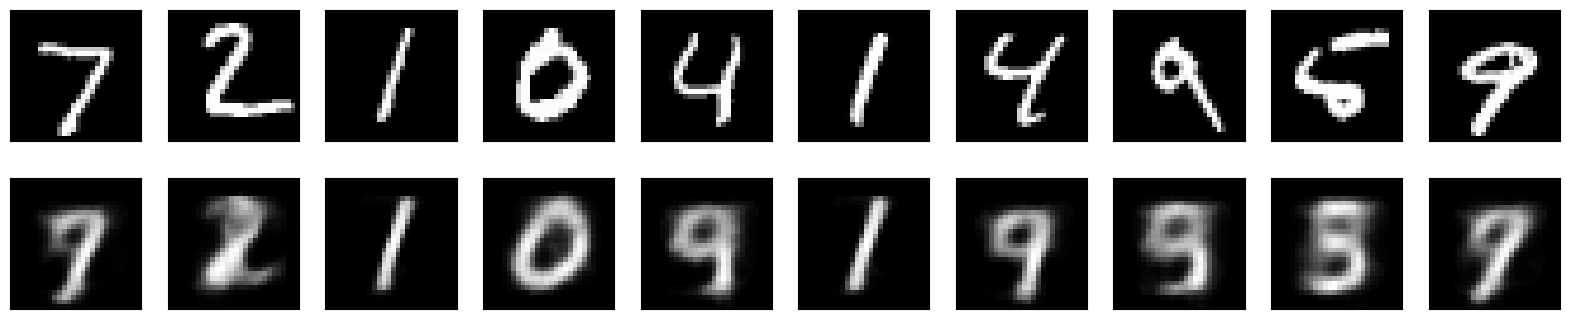

In [ ]:

encoded_imgs = autoenc_conv.getEncodedImage(x_test)
decoded_imgs = autoenc_conv.getDecodedImage(encoded_imgs)

plot_imgs(x_test, decoded_imgs, n=10)

# As expected, the reconstruction results are not so good, since we used only two dimensions for the embedding!

# **Display a grid of sampled digits**
* ## We Take the model as input, the number of samples to generate along the two latent dimensions, and the figure size to be cropped

In [27]:
def plot_latent_space(vae, n=30, figsize=15, digit_size=28):
    # display a n*n 2D manifold of digits
    scale = 10.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


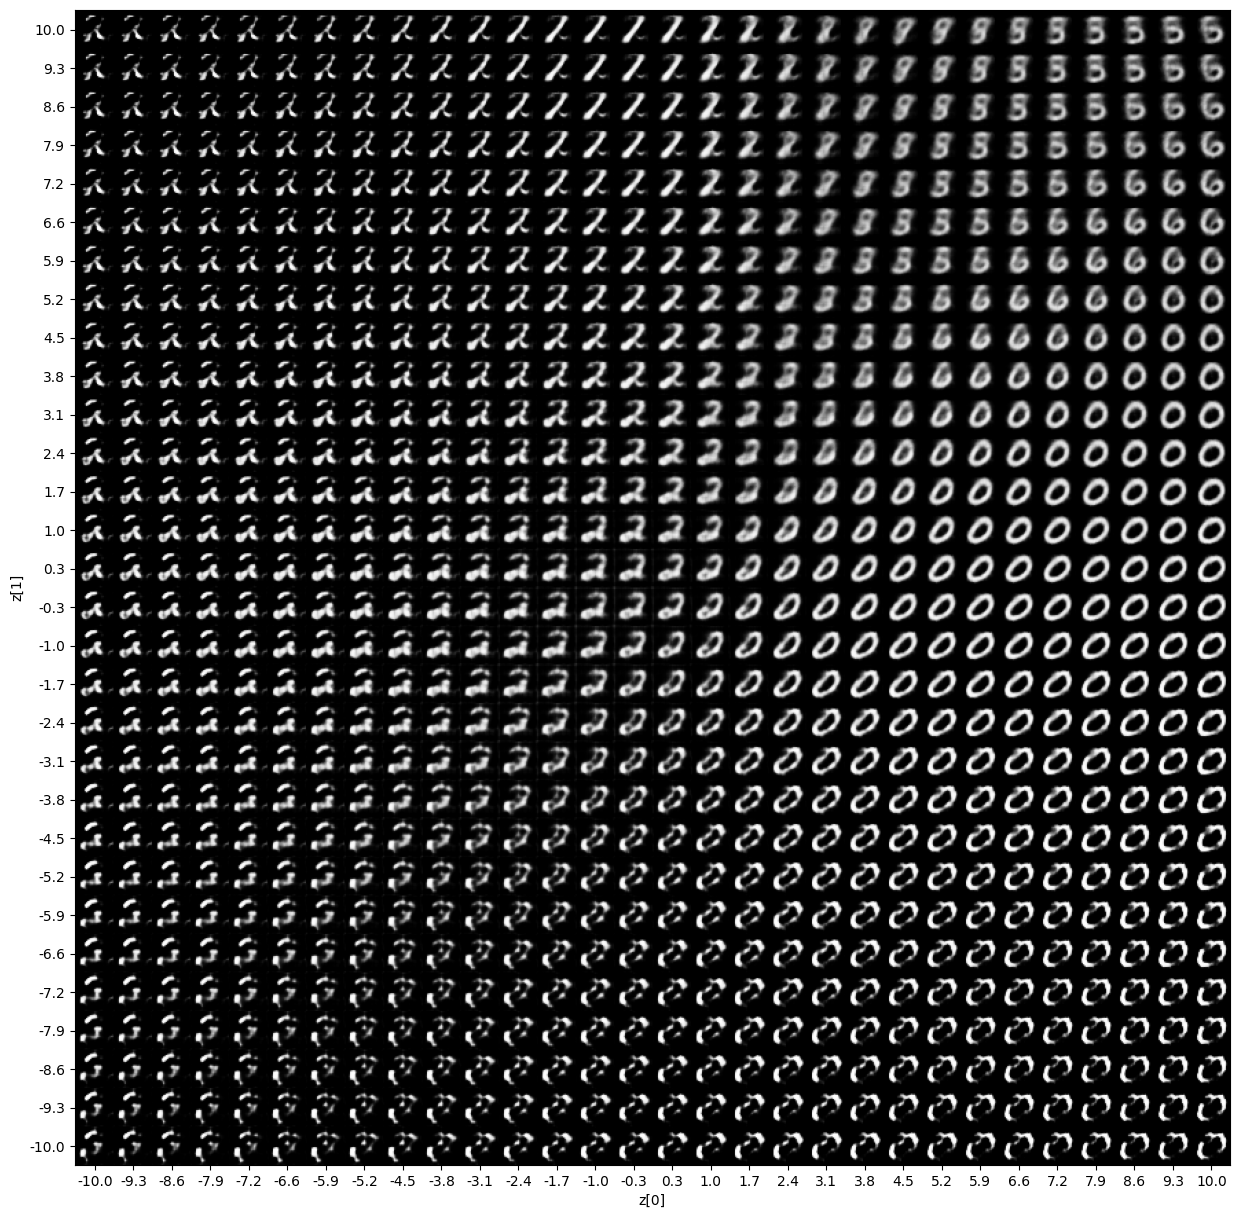

In [ ]:
plot_latent_space(autoenc_conv)

# **As we see, intermediate values do not correspond to any 'feasible' digit**
# Let's now implement a Variational Autoencoder!

## **Defining the sampling layer**

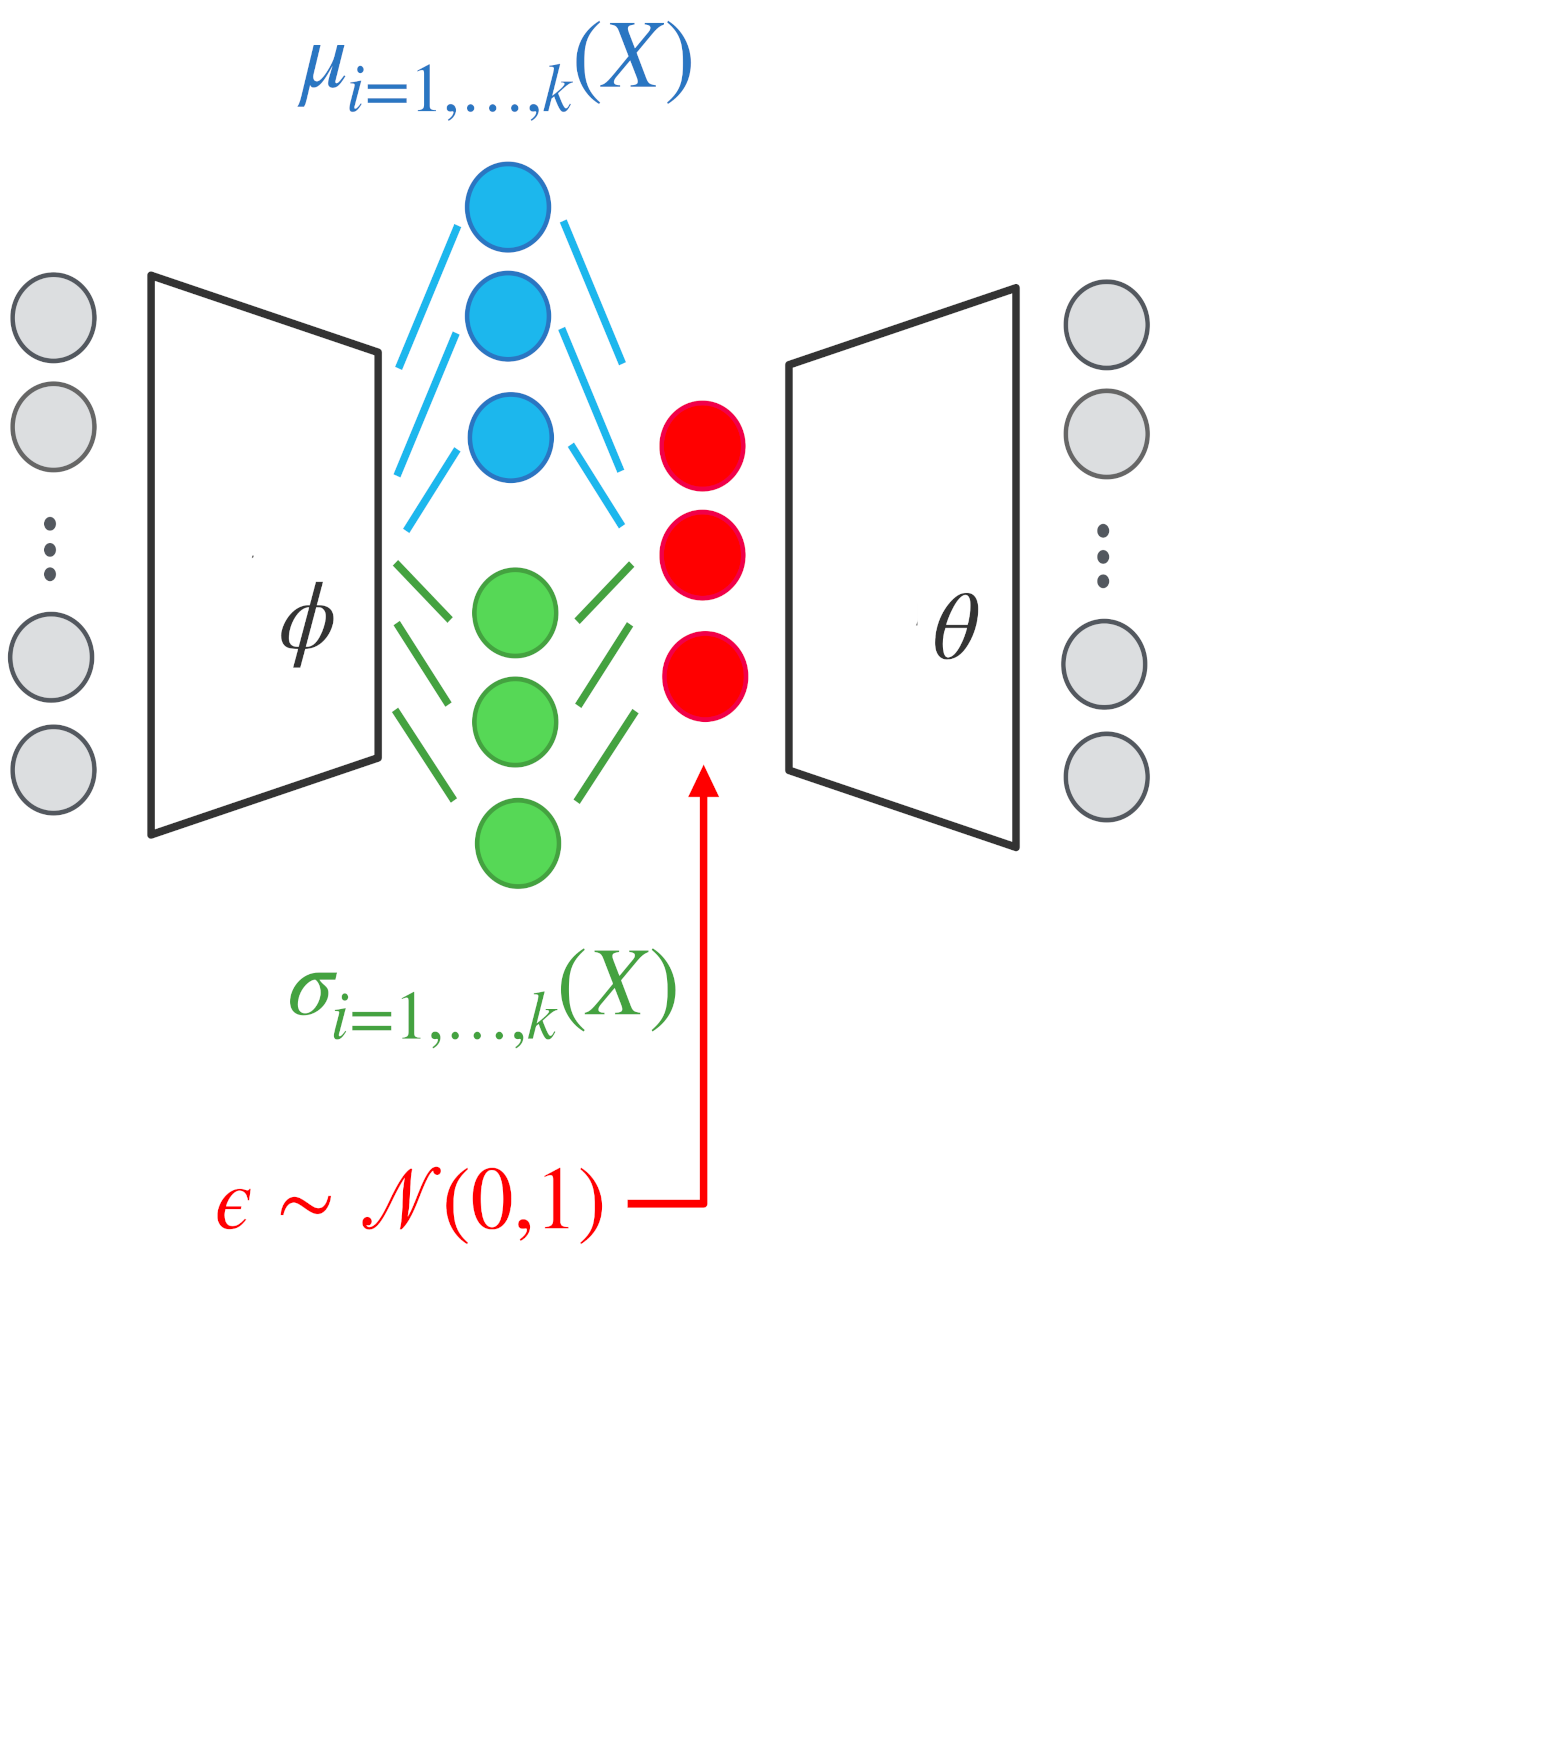

# **Remind we need two dense layers to fit the formula**
* ## $q_\phi(Z∣X):=N({dense{^1}}_\phi(X),exp({dense^2}_\phi(X))I)$
> * ## $dense^1$ and $dense^2$ are two Dense layers learning respectively the **mean** and **the logarithm of the variance** of the multivariate normal distribution to sample $Z$ from   
* ## We define a custom layer inherediting the `keras.layers.Layer` class
* ## It will output the $Z$ value corresponding to input values

In [2]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = K.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = K.random.normal(shape=(batch, dim), seed=self.seed_generator,
                                  mean=0, stddev=1,)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

# **Building the encoder**
* ## It has two 'parallel' dense layers at the end, one for $\mu$ values, one for the $\sigma$ values, or their logarithm
* ## And a final Sampling layer to output the $Z$ value
* ## It outputs the corresponding $\mu$, $\sigma$ and $Z$ value

In [33]:
# one Fully-Connected layer encoder
# ENCODING_DIM: This is the size of our encoded representations
def vae_enc(INPUT_SHAPE, latent_dim):
    enc_inputs = K.Input(shape=INPUT_SHAPE)
    tmp = layers.Conv2D(16, (3, 3), strides = 1,
                    activation='relu', padding='same')(enc_inputs)
    tmp = layers.MaxPooling2D((2, 2), padding='same')(tmp)
    tmp = layers.Conv2D(32, (3, 3),  strides = 1,
                    activation='relu', padding='same')(tmp)
    tmp = layers.MaxPooling2D((2, 2), padding='same')(tmp)
      # at this point the representation is (7, 7, 32)
    tmp = layers.Flatten()(tmp)
    tmp = layers.Dense(16, activation="relu")(tmp)
    z_mean = layers.Dense(latent_dim, activation="elu",
                   name="z_mean")(tmp)
    z_log_var = layers.Dense(latent_dim, activation="elu",
                   name="z_log_var")(tmp)
    z = Sampling()([z_mean, z_log_var])
    model = K.Model(enc_inputs, [z_mean, z_log_var, z],
                    name='Encoder')

    return model

# **Building the Decoder**

In [4]:
def vae_dec(latent_dim, out_activation='sigmoid'):
    latent_inputs = K.Input(shape=(latent_dim,))
    tmp = layers.Dense(16, activation="relu")(latent_inputs)
    tmp = layers.Dense(7*7*32, activation="relu")(tmp)
    tmp = layers.Reshape((7, 7, 32))(tmp)
    tmp = layers.Conv2DTranspose(32, (3, 3), strides = 2,
                  activation='relu', padding='same')(tmp)
    tmp = layers.Conv2DTranspose(16, (3, 3), strides = 2,
                  activation='relu', padding='same')(tmp)
    decoder_outputs = layers.Conv2D(1, (3, 3),
                                    activation=out_activation,
                                    padding='same')(tmp)
    model = K.Model(latent_inputs, decoder_outputs, name='Decoder')
    return model

# **Building the VAE**
* ## We need to define the custom loss as mean of MSE and KL of the prior p(Z) and the posterior p(Z|X)

In [34]:
class VAE(K.Model):
  def __init__(self, INPUT_SHAPE, ENCODING_DIM,
               enc_model, dec_model,
               out_activation='sigmoid',
               reg=1,
               **kwargs):
    super(VAE, self).__init__()
    #############################################
    #----------ENCODER--------------------------#
    # at this point the representation is (28,28,1)-dimensional
    self.latent_dim = ENCODING_DIM
    self.encoder = enc_model(INPUT_SHAPE, self.latent_dim)
    self.reg = reg

    self.out_activation = out_activation
    # at this point the representation is ENCODING_DIM-dimensional
    #############################################
    #----------DECODER--------------------------#
    self.decoder = dec_model(ENCODING_DIM, self.out_activation)
    ############################################
    # --------- LOSSES -------------------------#
    self.total_loss_tracker = K.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = K.metrics.Mean(
        name="reconstruction_loss"
        )
    self.kl_loss_tracker = K.metrics.Mean(name="kl_loss")

  ## Defining custom metrics as a model property
  ## so that they are added as metrics to track our the loss
  @property # property is a built-in decorator that turns a method
            #into a readable attribute without requiring parentheses when calling it.
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]
  ## Implementing a custom training step  that updates the state
  ##  of these metrics (by calling update_state() on them)
  @tf.function
  def train_step(self, data):
#    (x,y) = data
#    print(f"a.shspe:{x.shape}, b.shspe:{b.shape}")
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = ops.mean(
            ops.sum(
                #K.losses.binary_crossentropy(data, reconstruction),
                K.losses.MSE(data, reconstruction),
                axis=(1, 2),
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + self.reg*kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

  # method to encode images
  def getEncodedImage(self, image):
        encoded_image = self.encoder.predict(image)
        return encoded_image
# method to decode images
  def getDecodedImage(self, encoded_imgs):
      decoded_image = self.decoder.predict(encoded_imgs)
      return decoded_image

  def call(self, input):
    _,_,out_encoder = self.encoder(input)
    out_decoder = self.decoder(out_encoder)
    return out_decoder

# **Training the VAE**

In [35]:
input_shape = tuple(x_train.shape[1:])
ENCODING_DIM = 2

vae = VAE(input_shape,
          ENCODING_DIM,
          vae_enc,
          vae_dec,
          out_activation='sigmoid',
          reg=1)
print(vae.encoder.summary())
print(vae.decoder.summary())


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │        160 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 14, 14,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 14, 14,    │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 7, 7, 32)  │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1568)      │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │     25,104 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_3          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,972 (117.08 KB)

 Trainable params: 29,972 (117.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1568)           │        26,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,721 (159.07 KB)

 Trainable params: 40,721 (159.07 KB)

 Non-trainable params: 0 (0.00 B)

None


In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr = 0.0001 # default value for Adam
vae.compile(optimizer=K.optimizers.Adam(learning_rate=lr))
#lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.9,
#												threshold=0.0,
#												min_delta=0,
#	                                 patience=2,
#	                                 cooldown=0,
#	                                 verbose=1,
#	                                 min_lr = 10**-5)
#early_stopping = EarlyStopping(monitor='reconstruction_loss', mode='min', patience=15, verbose=0)
#callbacks_list = [lr_scheduler, early_stopping]
epochs = 50
batch_size=64
vae.fit(#mnist_digits, mnist_digits,
        x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        #callbacks=callbacks_list,
        verbose = 2)

Epoch 1/50
938/938 - 11s - 11ms/step - kl_loss: 1.1647 - loss: 72.5533 - reconstruction_loss: 71.3887
Epoch 2/50
938/938 - 6s - 6ms/step - kl_loss: 0.8385 - loss: 51.3868 - reconstruction_loss: 50.5483
Epoch 3/50
938/938 - 5s - 5ms/step - kl_loss: 1.5501 - loss: 48.3832 - reconstruction_loss: 46.8332
Epoch 4/50
938/938 - 4s - 4ms/step - kl_loss: 1.8933 - loss: 47.0729 - reconstruction_loss: 45.1796
Epoch 5/50
938/938 - 3s - 3ms/step - kl_loss: 2.0460 - loss: 46.5753 - reconstruction_loss: 44.5294
Epoch 6/50
938/938 - 6s - 6ms/step - kl_loss: 2.1415 - loss: 46.2572 - reconstruction_loss: 44.1158
Epoch 7/50
938/938 - 5s - 6ms/step - kl_loss: 2.2230 - loss: 46.0264 - reconstruction_loss: 43.8033
Epoch 8/50
938/938 - 3s - 3ms/step - kl_loss: 2.2960 - loss: 45.8336 - reconstruction_loss: 43.5376
Epoch 9/50
938/938 - 5s - 6ms/step - kl_loss: 2.3439 - loss: 45.6945 - reconstruction_loss: 43.3506
Epoch 10/50
938/938 - 3s - 4ms/step - kl_loss: 2.3978 - loss: 45.5910 - reconstruction_loss: 43.19

# **Let's reconstruct some testing images**

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


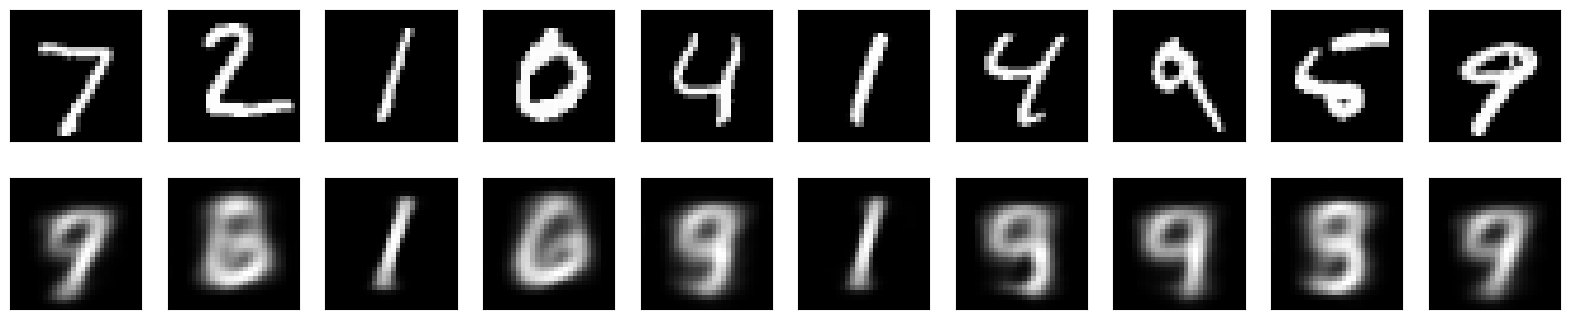

In [37]:
z_mean, z_log_var, encoded_imgs = vae.getEncodedImage(x_test)
decoded_imgs = vae.getDecodedImage(encoded_imgs)

plot_imgs(x_test, decoded_imgs, n=10)

# Again, as expected, the reconstruction is not good, since we used only two latent features
* ## I was visible already in the loss values, which only slightly decreased
* ## But we now plot the latent space in a gradual way, like done before

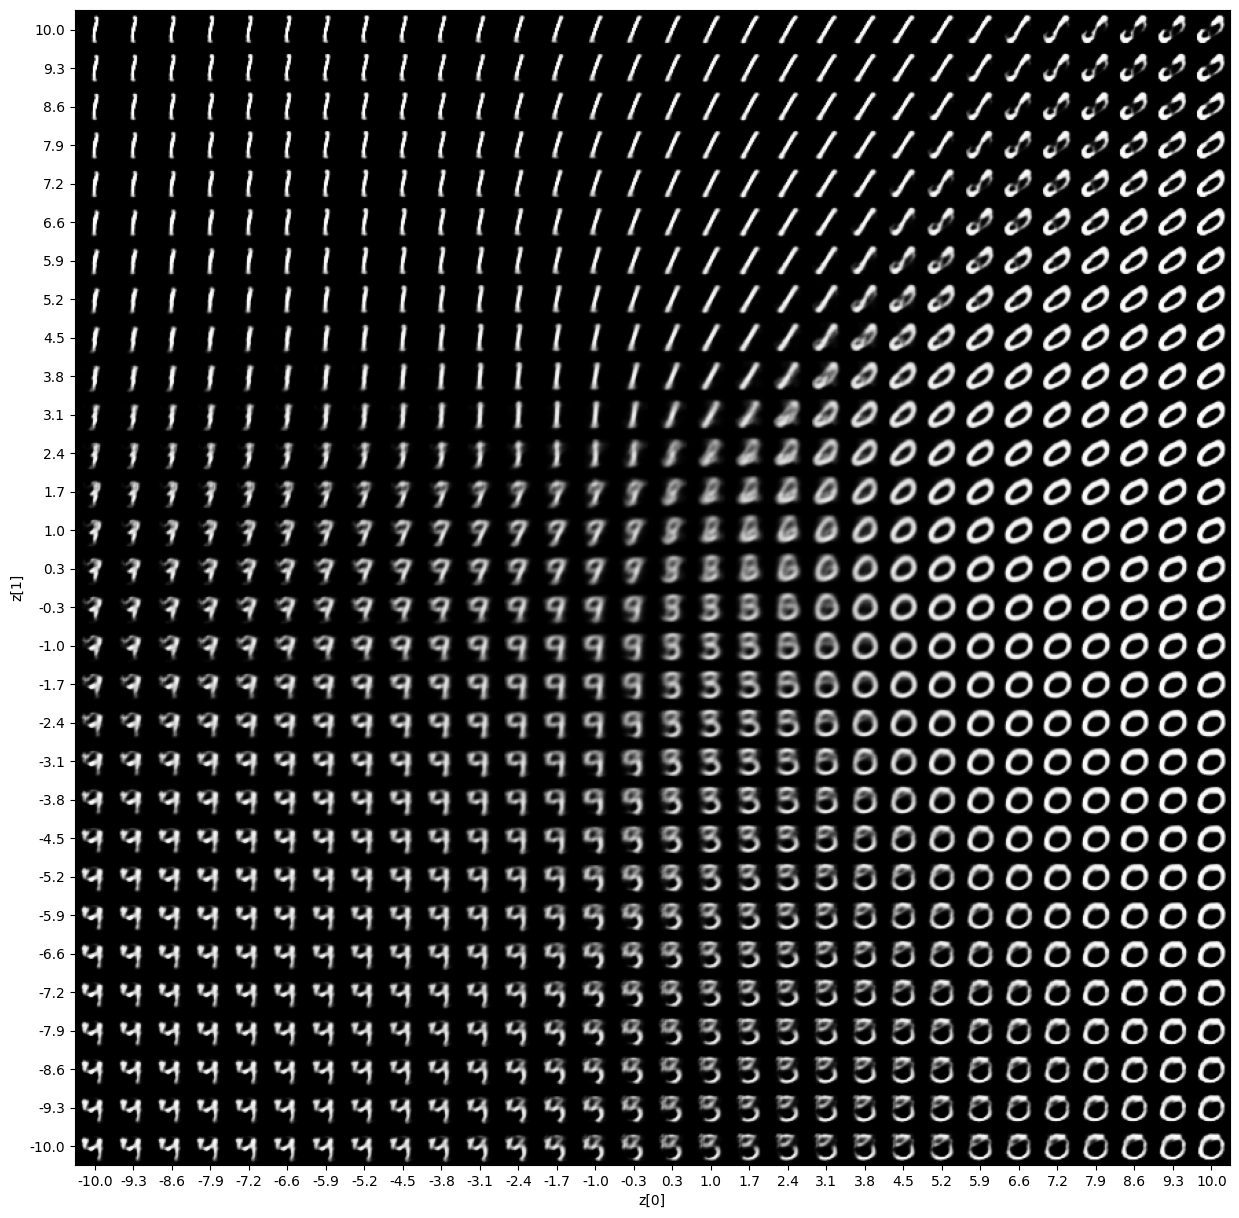

In [39]:
plot_latent_space(vae)

# Now moving from a region to another one is through intermediate digits!

# **Exercise**
## In the  ``total_loss`` computation (line 56 of the corresponding cell), try tests with reg >1 and reg<1, to check how the embedding varies (various classes should gather closer when reg>1)
## Evaluate how the digits distribute in the Z space when varying *reg*

# **Display how the latent space clusters different digit classes**

In [31]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    print(f"z_mean.shape:{z_mean.shape}")
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

z_mean.shape:(60000, 2)


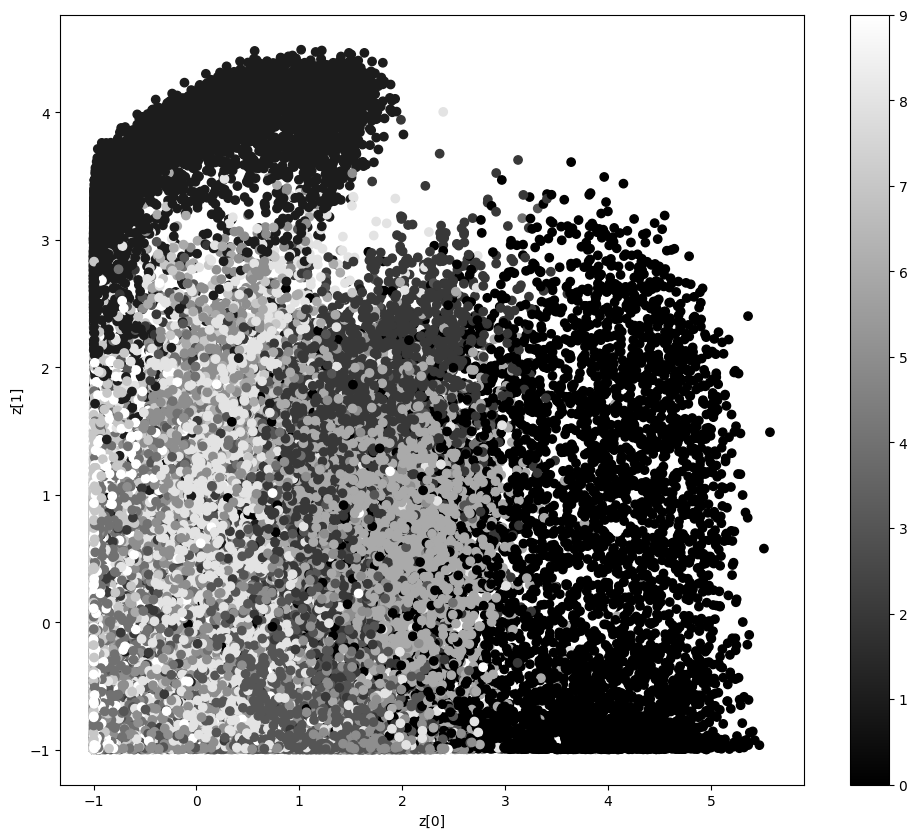

In [38]:
plot_label_clusters(vae, x_train, y_train)

# **Exercise**
* ## Using the image dataset of laboratory 12, implement a variational autoencoder, even with more that 2 latent embeddings
* ## Then explore the latent space by randomly sample z values and feeding it to the decoder
* ## Verify if the reconstructed images make sense with regard to the original images

# **Hopfield Networks**
* ## Let's try to implement from scratch a simply Hopfield net class
* ## We define a custom signum function for the neuron activation

In [10]:
import numpy as np
import math

def my_sign(x):
  return int(math.copysign(1, x))


print(my_sign(0.0001))
print(my_sign(-0.0001))
print(my_sign(0)) # 0 is considered positive

1
-1
1


In [11]:

class HopfieldNetwork:
    def __init__(self, size, max_epochs):
        self.size = size # number of neurons
        #initilizing weights
        self.weights = np.zeros((size, size))
        self.max_epochs = max_epochs

    def train(self, data):
        for pattern in data:
            # Hebbian rule
                # outer nx1 dot 1xn --> nxn
            self.weights += np.outer(pattern, pattern)
        self.weights /= len(data)
        ## No self loops in hopfield networks
        np.fill_diagonal(self.weights, 0)

    def predict(self, pattern):
        result = np.copy(pattern)

        for _ in range(self.max_epochs):  # number of iterations
            change = 0 # flag to get equilibrium state reached
            for i in range(self.size):
                # asynchronous update rule: weighted sum of the inputs
                if my_sign(np.dot(self.weights[i], result)) != result[i]:
                  result[i] = -result[i]
                  change=1

            if not change: # equilibrium state
              break
        return result

# **Setting the configuration**


In [12]:
pattern_size = 20
num_patterns = 3
noise_level = 0.2

# **Generating the patterns to be stored**
* ## For good results, patterns should be `far' enough


In [13]:
# define our patterns
patterns = np.array([
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1,-1, -1, -1, -1, -1],
   [-1, -1, -1, -1, -1,-1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1],
])
#patterns = generate_pattern(pattern_size, num_patterns)
print(patterns)
print(patterns.shape)

[[ 1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1]]
(3, 20)


# **Creating the Hopfield network and training it**

In [14]:
hopfield_net = HopfieldNetwork(pattern_size, max_epochs=20)
hopfield_net.train(patterns)

In [15]:
print(hopfield_net.weights)

[[ 0.          1.          1.          1.          0.33333333  0.33333333
   0.33333333  0.33333333  1.          1.         -0.33333333 -0.33333333
  -1.         -1.         -1.         -1.         -0.33333333 -0.33333333
  -0.33333333 -0.33333333]
 [ 1.          0.          1.          1.          0.33333333  0.33333333
   0.33333333  0.33333333  1.          1.         -0.33333333 -0.33333333
  -1.         -1.         -1.         -1.         -0.33333333 -0.33333333
  -0.33333333 -0.33333333]
 [ 1.          1.          0.          1.          0.33333333  0.33333333
   0.33333333  0.33333333  1.          1.         -0.33333333 -0.33333333
  -1.         -1.         -1.         -1.         -0.33333333 -0.33333333
  -0.33333333 -0.33333333]
 [ 1.          1.          1.          0.          0.33333333  0.33333333
   0.33333333  0.33333333  1.          1.         -0.33333333 -0.33333333
  -1.         -1.         -1.         -1.         -0.33333333 -0.33333333
  -0.33333333 -0.33333333]
 [ 0

# **Function to add noise**
* ## flip around ``noise_level`` \% of the bits in ``pattern`` uniformly at random

In [16]:
def add_noise(pattern, noise_level):
    noise = np.random.choice([1, -1], pattern.shape, p=[1-noise_level, noise_level])
    return pattern * noise

# **Function to compute accuracy of reconstruction**

In [17]:
# accuracy of reconstructed inputs
def recon_accuracy(recon, true):
  return np.sum(recon== true)/len(recon)

# **Testing it**

In [18]:
num_test = num_patterns
test_pattern = add_noise(patterns[:num_test], noise_level)
for i in range(num_test):
  recovered_pattern = hopfield_net.predict(test_pattern[i])
  print("\tOriginal pattern:  ", patterns[i])
  print("\tNoisy pattern:     ", test_pattern[i])
  print("\tRecovered pattern: ", recovered_pattern)
  print(f"\t pattern:{i}, original % of difference:{1-recon_accuracy(patterns[i], test_pattern[i])}")
  print(f"\t pattern:{i}, recon accuracy:{recon_accuracy(patterns[i], recovered_pattern)}")
  print("----------------------------------")

	Original pattern:   [ 1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
	Noisy pattern:      [ 1 -1  1  1  1  1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1]
	Recovered pattern:  [ 1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
	 pattern:0, original % of difference:0.19999999999999996
	 pattern:0, recon accuracy:1.0
----------------------------------
	Original pattern:   [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1]
	Noisy pattern:      [-1  1  1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1  1  1  1  1  1  1]
	Recovered pattern:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1]
	 pattern:1, original % of difference:0.25
	 pattern:1, recon accuracy:1.0
----------------------------------
	Original pattern:   [ 1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1]
	Noisy pattern:      [ 1  1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1 -1  1 -1  1  1]
	Recovered pattern:  [ 1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1]
	 pattern:2, origi

# **The reconstruction is perfect!**
# **Let's try with random patterns**

# **Function to generate random patterns in $\{-1,1\}^n$**

In [21]:
def generate_random_pattern(size, num_patterns):
    return np.random.choice([-1, 1], (num_patterns, size))

In [22]:
patterns = generate_random_pattern(pattern_size, num_patterns)
print(patterns)
print(patterns.shape)

[[ 1 -1  1 -1  1  1 -1  1  1  1 -1  1 -1 -1  1  1 -1  1  1  1]
 [ 1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1 -1  1 -1]
 [-1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1 -1 -1  1]]
(3, 20)


In [23]:
hopfield_net = HopfieldNetwork(pattern_size, max_epochs=20)
hopfield_net.train(patterns)
num_test = num_patterns
test_pattern = add_noise(patterns[:num_test], noise_level)
for i in range(num_test):
  recovered_pattern = hopfield_net.predict(test_pattern[i])
  print("\tOriginal pattern:  ", patterns[i])
  print("\tNoisy pattern:     ", test_pattern[i])
  print("\tRecovered pattern: ", recovered_pattern)
  print(f"\t pattern:{i}, original % of difference:{1-recon_accuracy(patterns[i], test_pattern[i])}")
  print(f"\t pattern:{i}, recon accuracy:{recon_accuracy(patterns[i], recovered_pattern)}")
  print("----------------------------------")

	Original pattern:   [ 1 -1  1 -1  1  1 -1  1  1  1 -1  1 -1 -1  1  1 -1  1  1  1]
	Noisy pattern:      [ 1 -1 -1 -1  1  1 -1  1 -1  1  1 -1 -1 -1  1  1 -1  1 -1  1]
	Recovered pattern:  [ 1 -1  1 -1  1  1 -1  1  1  1 -1  1 -1 -1  1  1 -1  1  1  1]
	 pattern:0, original % of difference:0.25
	 pattern:0, recon accuracy:1.0
----------------------------------
	Original pattern:   [ 1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1 -1  1 -1]
	Noisy pattern:      [ 1  1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1  1  1  1  1  1 -1]
	Recovered pattern:  [ 1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1 -1  1 -1]
	 pattern:1, original % of difference:0.4
	 pattern:1, recon accuracy:1.0
----------------------------------
	Original pattern:   [-1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1 -1 -1  1]
	Noisy pattern:      [ 1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1]
	Recovered pattern:  [-1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1  1]
	 pattern:2, original % of differe

# With randomly generated patterns, the network is attacted by other attactors (minima), and do not reconstruct perfectly in some cases
* ## but however can reduce the initial gap